<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/classification_medical_risks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task description

The goal is to build a predictive model to assess the risk level of pregnant women based on medical indicators.

**Metric:** For this predictive model, Recall is the primary metric because it is critical to correctly identify as many high-risk cases as possible, minimizing the chance of missing a true high-risk pregnancy. We will also report the weighted F1-score to provide a balanced evaluation of the model's performance across all risk levels, which is important given the imbalanced distribution of the target classes.

**Data description:**
- `Age`: Age in years when a woman is pregnant.
- `SystolicBP`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `DiastolicBP`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `BS`: Blood glucose levels is in terms of a molar concentration, mmol/L.
- `HeartRate`: A normal resting heart rate in beats per minute.
- `Risk Level`: Predicted Risk Intensity Level during pregnancy considering the previous attribute. The target variable, Risk Level, has three categories: Low Risk, Mid Risk, and High Risk.


**Steps:**
- [Loading dataset](#scrollTo=uALUhlU7JSWy&line=1&uniqifier=1)
- [Exploratory data analysis and Correlation Matrix](#scrollTo=F8fwut1qzCh4&line=1&uniqifier=1)
- [Data preprocessing](#scrollTo=iLguJHd2JZRT&line=1&uniqifier=1)
- [Model Selection and Hyperparameter Tuning](#scrollTo=ezcvy2X82QcR&line=1&uniqifier=1)
- [Final Model Training and Evaluation](#scrollTo=GeTUDptlAkI-&line=1&uniqifier=1)
- [Conclusion](#scrollTo=n5YPLVcHqatV&line=1&uniqifier=1)

## Loading dataset

**Library imports:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# file reading
df = pd.read_csv('/content/drive/MyDrive/Job/test tasks/data.csv')

# general info & first 5 rows of the tables
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
# let's check duplicates
df.duplicated().sum()

np.int64(562)

- No missing values
- Data types are all correct
- There duplicated objects, more than half of dataset. But let's explore before deleting them.

In [4]:
# check for exact duplicates
duplicates = df[df.duplicated(keep=False)]

# group them to see the identical sets
duplicates.sort_values(list(df.columns)).head(20)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
670,10,100,50,6.0,99.0,70,mid risk
849,10,100,50,6.0,99.0,70,mid risk
552,12,90,60,7.5,102.0,60,low risk
940,12,90,60,7.5,102.0,60,low risk
543,12,90,60,7.5,102.0,66,low risk
934,12,90,60,7.5,102.0,66,low risk
588,12,90,60,7.5,102.0,66,mid risk
827,12,90,60,7.5,102.0,66,mid risk
171,12,90,60,7.9,102.0,66,high risk
963,12,90,60,7.9,102.0,66,high risk


In [5]:
# let's delete dublicates
df.drop_duplicates(inplace=True)

## Exploratory Data Analysis & Correlation Matrix

In [6]:
# let's look on statistics of dataset
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,29.194690,110.553097,75.418142,8.346173,98.692478,73.949115
std,13.767379,17.872282,13.754578,2.829209,1.410897,8.156973
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,90.000000,65.000000,6.900000,98.000000,70.000000
50%,25.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,35.000000,120.000000,86.000000,7.900000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


- There are upper outliers in `BS` & lower ourliers in `HeartRate`.
- Pregnancy at 70 is very rare case..Natural pregnancy after ~50 is extremely unlikely due to menopause (usually between ages 45–55). With assisted reproductive technologies (IVF with donor eggs), pregnancies have occurred even at ages 60–70 — but these are exceptional and often carry very high medical risk.

Let's look at visualization of features' distribution.


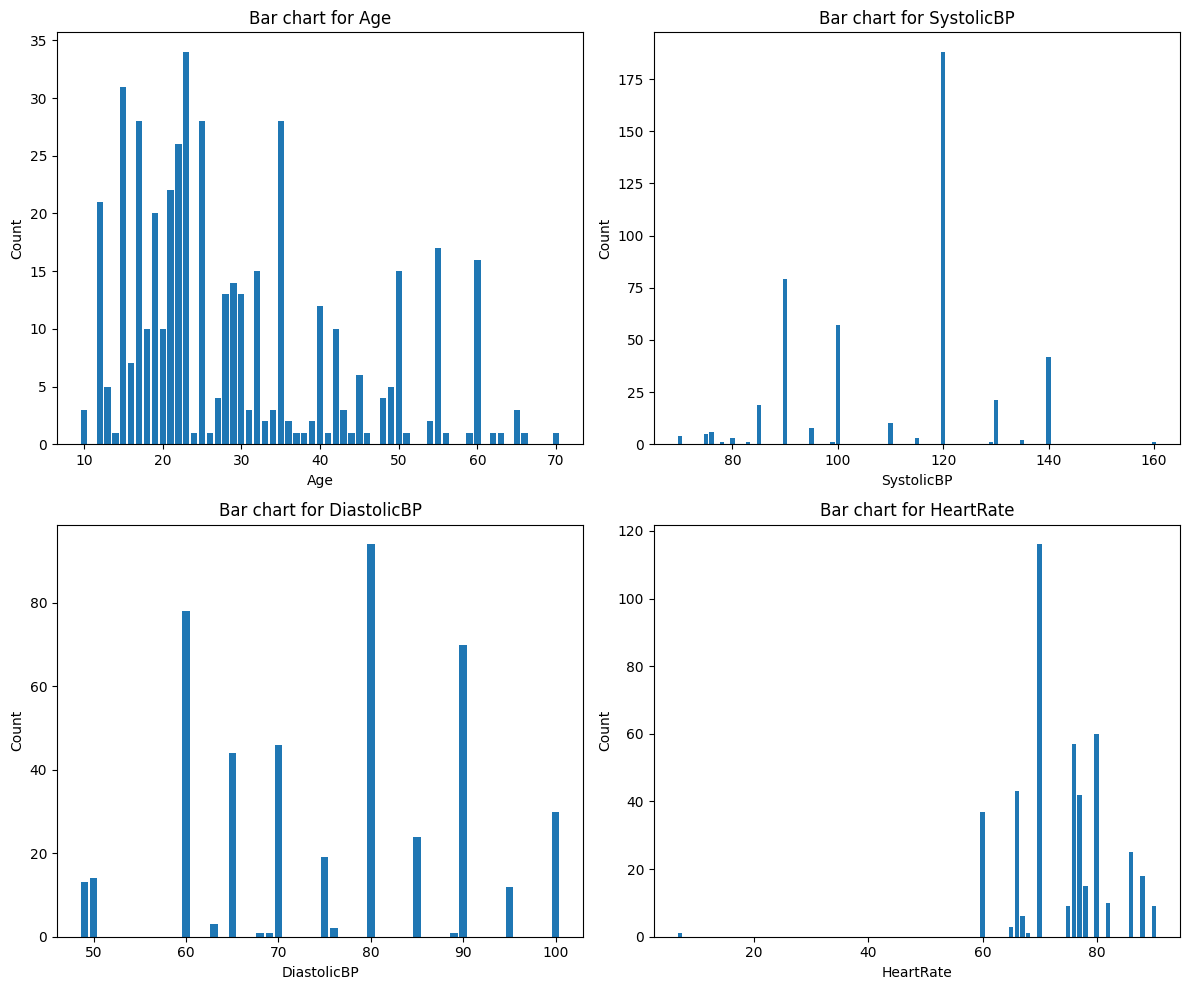

In [7]:
# let's make function for vizualization of features with integer values
int_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']

def plot_int_features(features):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  axes = axes.flatten()

  for i, feature in enumerate(features):
    axes[i].bar(df[feature].value_counts().index, df[feature].value_counts())
    axes[i].set_title(f'Bar chart for {feature}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(feature)

  plt.tight_layout()
  plt.show()

plot_int_features(int_features)

- It is obvious that there is anomaly in `HeartRate` (> 20), which should be deleted.
- Regarding distribution of `Age` and `SystolicBP`, they still need to be explored in more detail.
- Overall, all 4 features are not normally distributed.

In [8]:
# let's delete anomaly in HeartRate
df = df[df['HeartRate'] > 40]

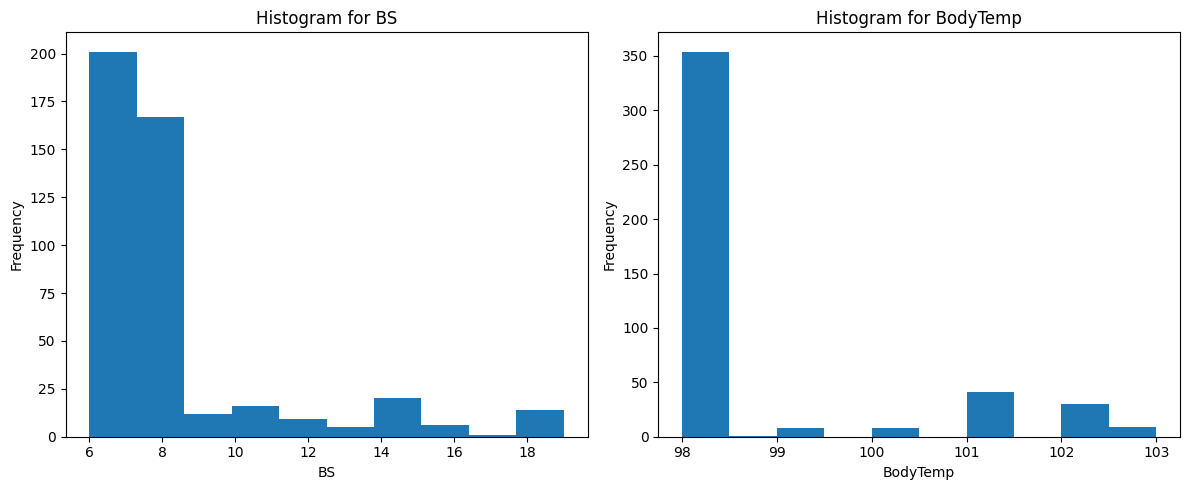

In [9]:
# let's make function for vizualization of float features with histograms
float_features = ['BS', 'BodyTemp']

def plot_float_features_histograms(features):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes = axes.flatten()

  for i, feature in enumerate(features):
    axes[i].hist(df[feature])
    axes[i].set_title(f'Histogram for {feature}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel(feature)

  plt.tight_layout()
  plt.show()

plot_float_features_histograms(float_features)

`BS` and `BodyTemp` has skewed to the right distribution, which means most values are clustered on the lower side (left side), but a few unusually high values stretch the distribution to the right. Let's look on boxplot of features.

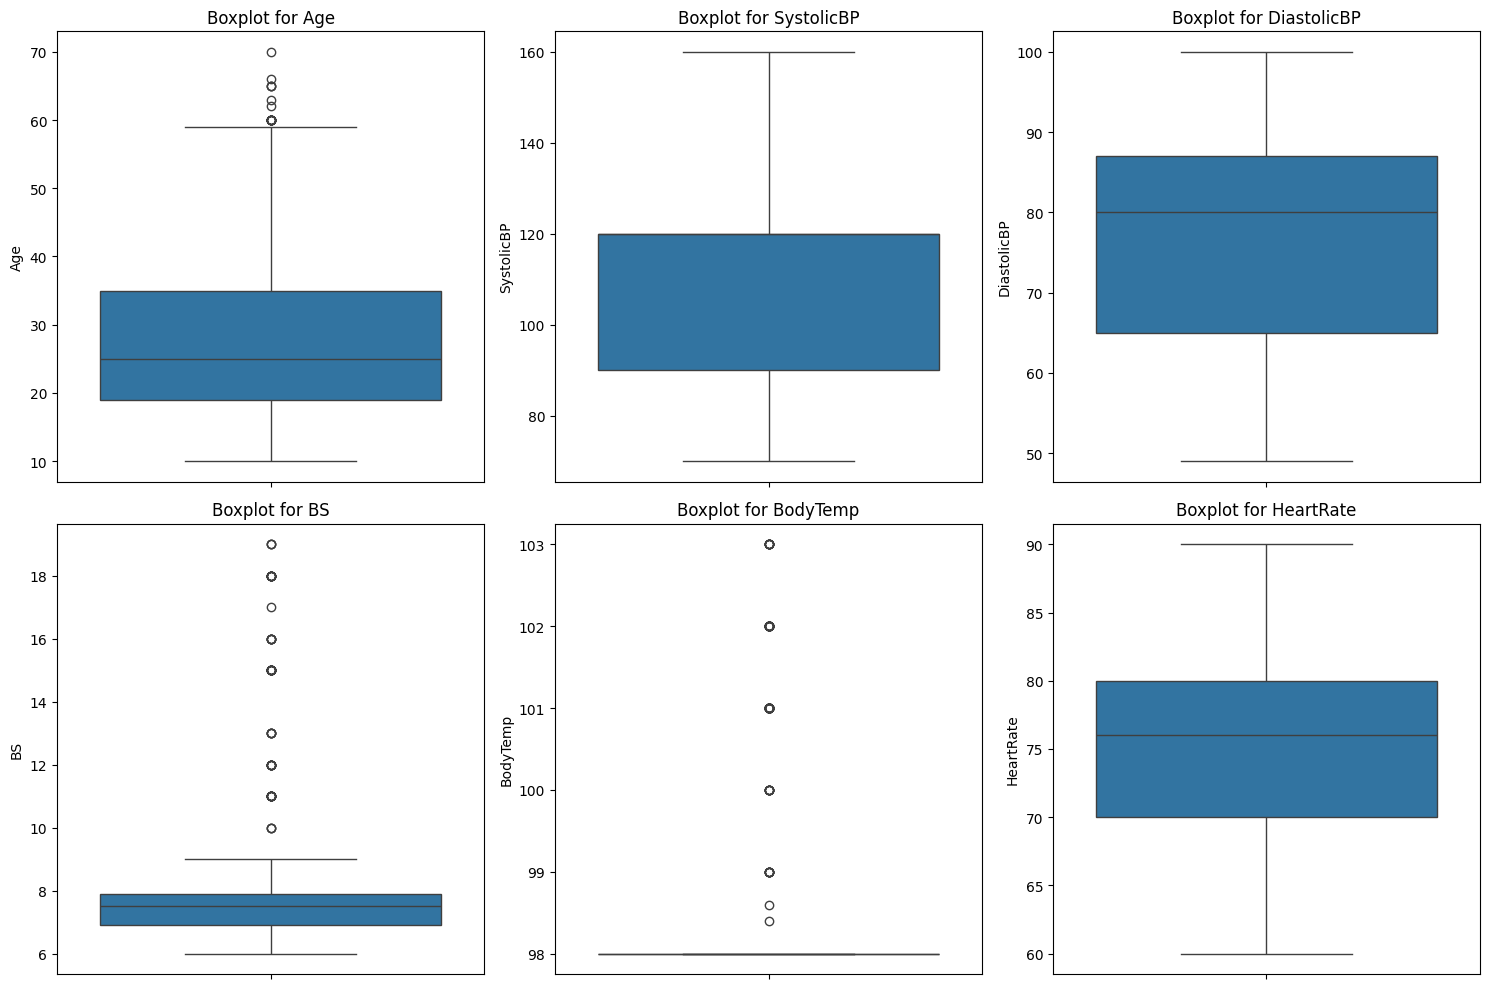

In [10]:
# let's make function for vizualization of numerical features with boxplots
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

def plot_numerical_features_boxplots(features):
  fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # Adjust grid size based on number of features
  axes = axes.flatten()

  for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot for {feature}')
    axes[i].set_ylabel(feature)

  plt.tight_layout()
  plt.show()

plot_numerical_features_boxplots(numerical_features)

- The distribution of `BodyTemp` is very compressed around 98 °F. There are a few plausible fever outliers (102–103 °F). No hypothermia cases (<95 °F), which is unusual but could be due to data collection choices.

- Outliers in `BS` are no impossible anomalies — just extreme values, because:

*ACOG / American College of Obstetricians and Gynecologists recommends:*
- Fasting ≤ 5.3 mmol/L
- 1-hour post-meal < 10.0 mmol/L
- 2-hour post-meal < 8.6 mmol/L

In [11]:
# let's look what characteristics have pragnant women older 60
df[df['Age'] >= 60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
36,60,120,80,6.1,98.0,75,low risk
54,60,90,65,7.0,98.0,77,low risk
91,60,120,85,15.0,98.0,60,mid risk
99,60,90,65,6.8,98.0,77,mid risk
114,63,140,90,15.0,98.0,90,high risk
181,60,120,85,15.0,98.0,60,high risk
280,60,120,80,7.7,98.0,75,low risk
309,60,90,65,6.9,98.0,77,low risk
313,62,120,80,6.9,98.0,66,low risk
322,65,90,60,6.9,98.0,70,low risk


This objects looks like errors because they are inonsistent in relation of features to target. Pregnant women older 55-60 is considered to have high risk, but here some of them are labeled as low risk.  

**For example**, in dataset objects with similar characteristics have different labeling risk level:

| Age | SystolicBP | DiastolicBP | BS   | BodyTemp | HeartRate | RiskLevel |
|-----|------------|-------------|------|----------|-----------|-----------|
| 60  | 120        | 85          | 15.0 | 98.0     | 60        | mid risk  |
| 60  | 120        | 85          | 15.0 | 98.0     | 60        | high risk |

Or pragnant woman at 70 has low risk:

| Age | SystolicBP | DiastolicBP | BS   | BodyTemp | HeartRate | RiskLevel |
|-----|------------|-------------|------|----------|-----------|-----------|
| 70  | 85         | 60          | 6.9  | 102.0    | 70        | low risk  |

Let's delete objects older or equal 60 because it will confuse our ML model.

In [12]:
# let's delete objects equal or older 60
df = df[df['Age'] < 60]

In [13]:
# let's reset index
df = df.reset_index(drop=True)

In [14]:
# the last check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          428 non-null    int64  
 1   SystolicBP   428 non-null    int64  
 2   DiastolicBP  428 non-null    int64  
 3   BS           428 non-null    float64
 4   BodyTemp     428 non-null    float64
 5   HeartRate    428 non-null    int64  
 6   RiskLevel    428 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 23.5+ KB


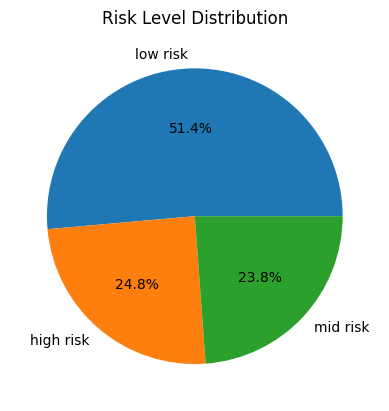

In [15]:
# let's look at target distribution
plt.pie(df['RiskLevel'].value_counts(normalize=True), labels=df['RiskLevel'].value_counts().index, autopct='%1.1f%%')
plt.title('Risk Level Distribution')
plt.show()

Taraget's class distribution is not extreme, but it’s still imbalanced (low risk is ~2× mid risk, and high risk is smallest). Weighted F1 will account for this imbalance by giving each class a proportional weight in the average.

Let's check correlation *Feature–target correlation* and *Feature–feature correlation* (to check for multicollinearity).

## Correlation check

Correlation with target:
BS             0.535574
SystolicBP     0.310753
BodyTemp       0.284340
DiastolicBP    0.243815
Age            0.231762
HeartRate      0.191187
Name: RiskLevel_encoded, dtype: float64


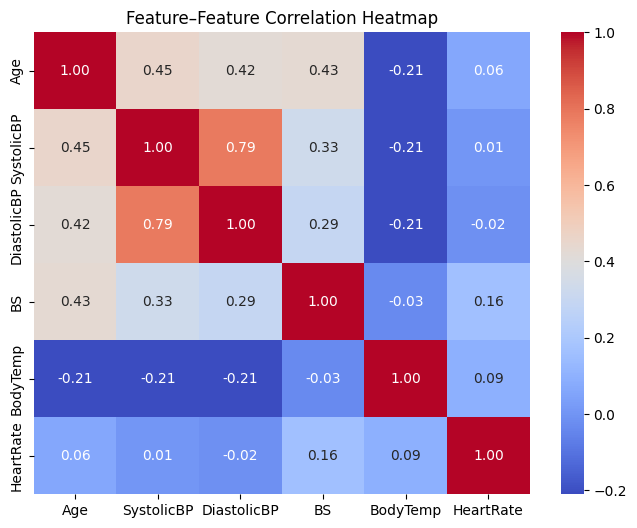

In [16]:
# encoding target for correlation (since RiskLevel is categorical)
df_corr = df.copy()
df_corr['RiskLevel_encoded'] = df_corr['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

# 1. feature–target correlation
corr_with_target = df_corr.corr(numeric_only=True)['RiskLevel_encoded'].drop('RiskLevel_encoded')
print("Correlation with target:")
print(corr_with_target.sort_values(ascending=False))

# 2. feature–feature correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature–Feature Correlation Heatmap")
plt.show()

- The target variable shows the highest correlation with Blood Sugar (0.53), which indicates a moderate positive relationship.
- SystolicBP (0.31), BodyTemp (0.28), DiastolicBP (0.24), Age (0.23), and HeartRate (0.19) have weaker correlations with the target.
- SystolicBP and DiastolicBP highly correlated ~0.8.

**Feature–target relationship visualization**

Let's have a look to the shape of relationships in order to choose better ML model.

/usr/local/lib/python3.11/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


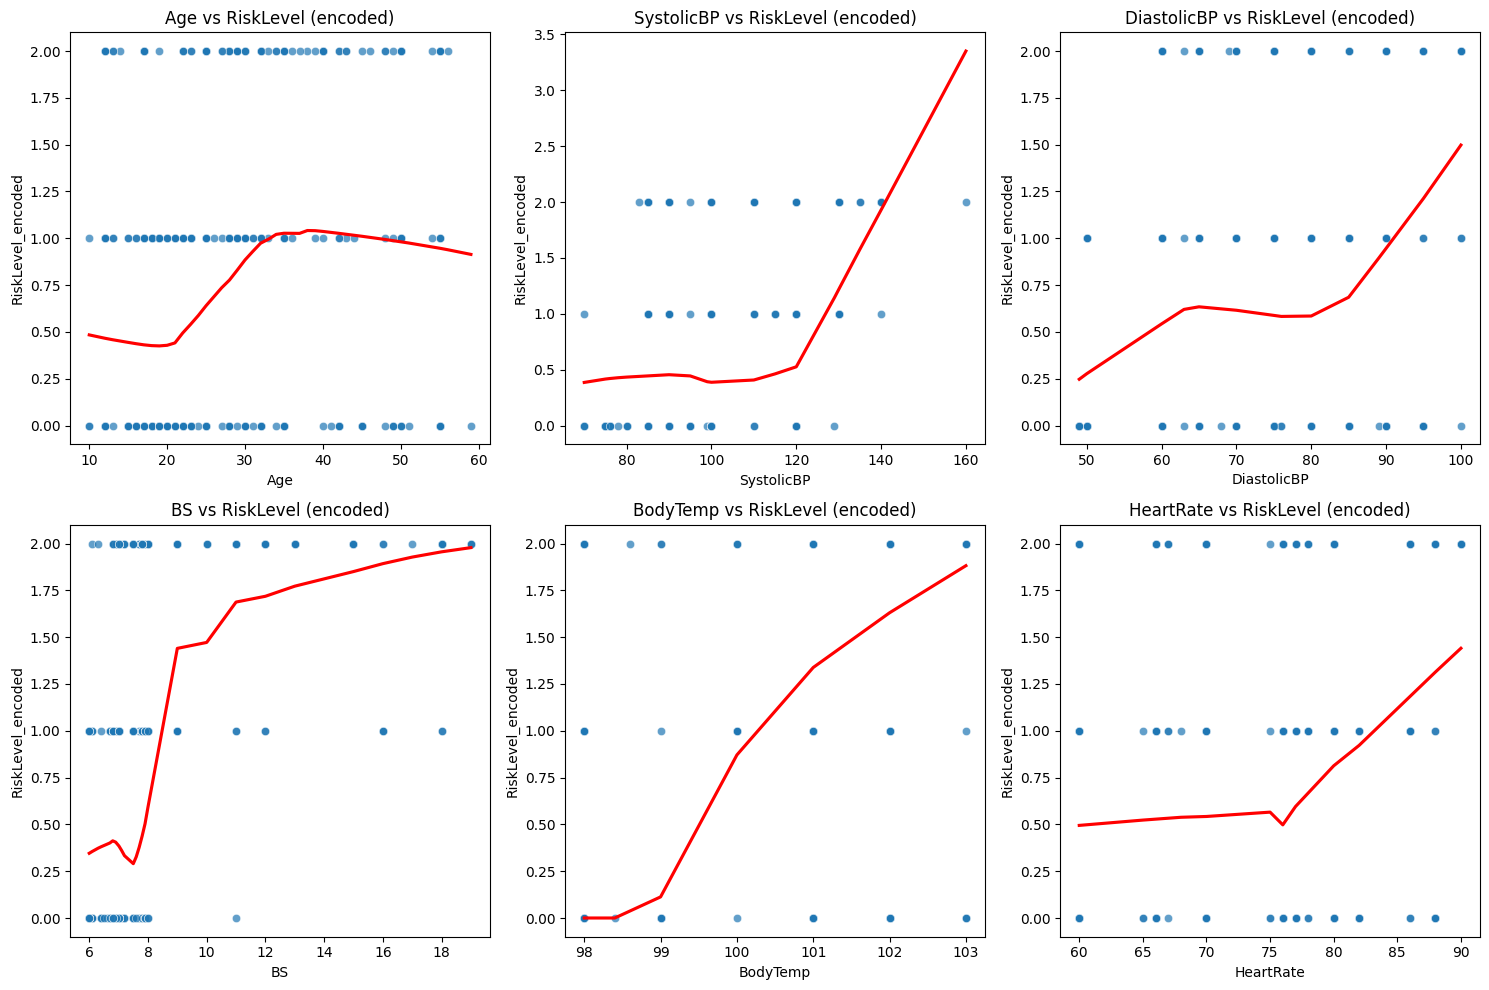

In [17]:
# let's seperate our target
features = features = df_corr.drop(columns=['RiskLevel', 'RiskLevel_encoded']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns of subplots

    # scatter points (feature vs encoded target)
    sns.scatterplot(x=df_corr[col], y=df_corr['RiskLevel_encoded'], alpha=0.7)

    # fit a LOWESS (locally weighted scatterplot smoothing) curve
    sns.regplot(
        x=df_corr[col],
        y=df_corr['RiskLevel_encoded'],
        scatter=False,
        lowess=True,
        color='red'
    )

    plt.title(f'{col} vs RiskLevel (encoded)')

plt.tight_layout()
plt.show()

- There are upward trend for features meaning that their higher values are associated with higher risks.
- No feature exhibits a strong linear correlation, suggesting that the model should rely on a combination of features rather than a single predictor. We should consider this fact when choosing ML models.


## Data preprocessing

In [18]:
# encoding target
le = LabelEncoder()
df['RiskLevel'] = le.fit_transform(df['RiskLevel'])

# separating target
X = df.drop(columns=['RiskLevel'])
y = df['RiskLevel']

In [19]:
# identifying the integer label for 'high risk' for recall calculation
high_risk_label = le.transform(['high risk'])[0]

## Model Selection and Hyperparameter Tuning

We will testing Decision Tree and Gradient Boosting (LightGBM).

**Decision Tree**:
- Captures non-linear relationships well.
- Work with small dataset - doesn’t need massive data to generalize reasonably well.
- Easy to intepret.

**LightGBM**:
- Handle non-linearities and complex patterns extremely well.
- Often outperform single trees and random forests in tabular classification tasks.
- Can deal with imbalanced datasets by adjusting class weights or learning rates.

In [20]:
# parameter grids
param_grids = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [3, 5, 7, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.05, 0.1],
            "max_depth": [-1, 5]
        }
    }
}

We’re doing cross-validation because your dataset is small and imbalanced, so we want to:

- Maximize training data usage (every row is used for both training and validation in different folds).

- Get a more reliable performance estimate than a single train/test split.

In [21]:
# custom scorers
scorers = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_high_risk': make_scorer(recall_score, average=None, labels=[high_risk_label])
}

In [22]:
# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for name, cfg in param_grids.items():
    grid = GridSearchCV(
        estimator=cfg["model"],
        param_grid=cfg["params"],
        scoring=scorers,
        refit='recall_high_risk',  # main optimization metric
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X, y)
    best_models[name] = grid.best_estimator_
    print(f"--- {name} Results ---")
    print(f"Best CV Recall for High Risk: {grid.best_score_:.4f}")
    print(f"Best Parameters: {grid.best_params_}\n")

--- Decision Tree Results ---
Best CV Recall for High Risk: 0.8009
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}

--- LightGBM Results ---
Best CV Recall for High Risk: 0.7732
Best Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 50}



The Decision Tree model has a higher recall score for the critical "high risk" class (0.8009 vs. 0.7732). This means that during cross-validation, it was better at correctly identifying the actual high-risk cases.

## Final Model Training and Evaluation

--- Decision Tree Metrics and Confusion Matrix ---

TRAIN SET:
              precision    recall  f1-score   support

   high risk       0.78      0.95      0.86        85
    low risk       0.83      0.93      0.87       176
    mid risk       0.88      0.44      0.59        81

    accuracy                           0.82       342
   macro avg       0.83      0.77      0.77       342
weighted avg       0.83      0.82      0.80       342


TEST SET:
              precision    recall  f1-score   support

   high risk       0.56      0.71      0.62        21
    low risk       0.66      0.70      0.68        44
    mid risk       0.25      0.14      0.18        21

    accuracy                           0.57        86
   macro avg       0.49      0.52      0.50        86
weighted avg       0.53      0.57      0.55        86



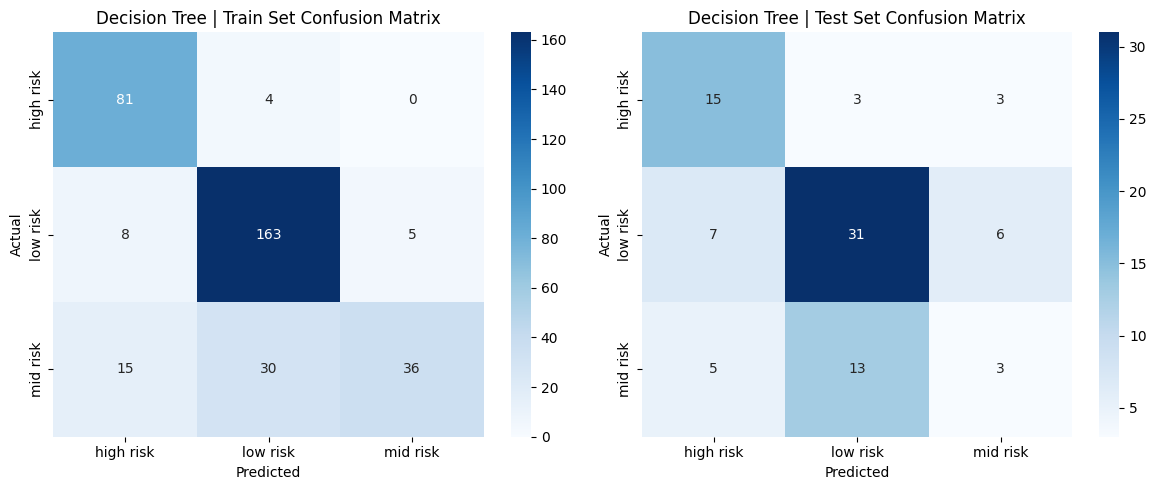

--- LightGBM Metrics and Confusion Matrix ---

TRAIN SET:
              precision    recall  f1-score   support

   high risk       0.87      0.88      0.88        85
    low risk       0.79      0.95      0.86       176
    mid risk       0.82      0.44      0.58        81

    accuracy                           0.81       342
   macro avg       0.83      0.76      0.77       342
weighted avg       0.82      0.81      0.80       342


TEST SET:
              precision    recall  f1-score   support

   high risk       0.74      0.81      0.77        21
    low risk       0.71      0.82      0.76        44
    mid risk       0.33      0.19      0.24        21

    accuracy                           0.66        86
   macro avg       0.59      0.61      0.59        86
weighted avg       0.62      0.66      0.64        86



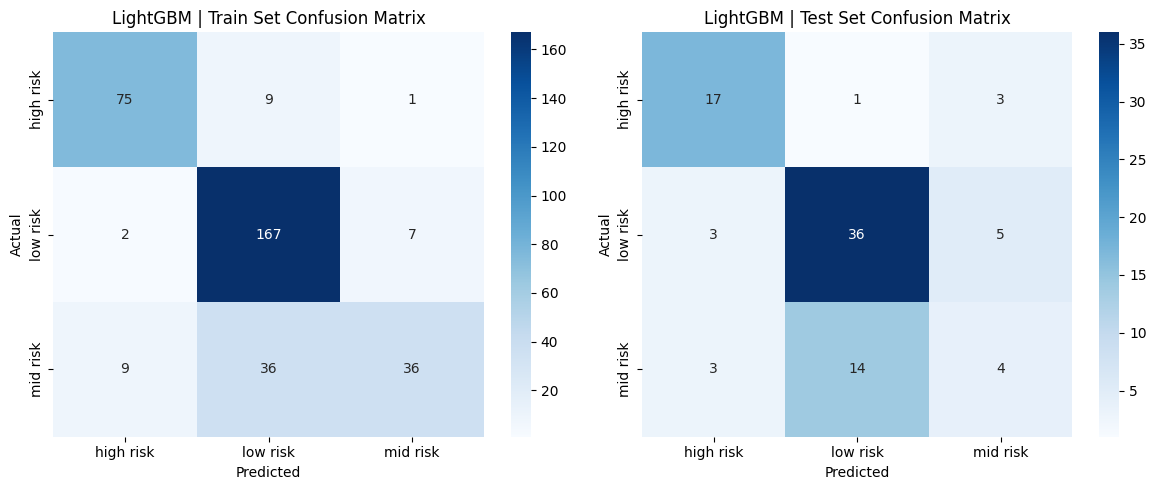

In [23]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# re-fit the best models on the full training data
for name, model in best_models.items():
    model.fit(X_train, y_train)

    # predictions for train and test sets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print(f"--- {name} Metrics and Confusion Matrix ---")
    print("\nTRAIN SET:")
    # Print metrics and classification report
    print(classification_report(y_train, train_preds, target_names=le.classes_))

    # plot confusion matrix for train set
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm_train = confusion_matrix(y_train, train_preds)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=le.classes_, yticklabels=le.classes_)
    axes[0].set_title(f"{name} | Train Set Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    print("\nTEST SET:")
    # print metrics and classification report
    print(classification_report(y_test, test_preds, target_names=le.classes_))

    # plot confusion matrix for test set
    cm_test = confusion_matrix(y_test, test_preds)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=le.classes_, yticklabels=le.classes_)
    axes[1].set_title(f"{name} | Test Set Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

## Conclusion

**LightGBM** is the superior model and is a more robust predictor. It's better at identifying high-risk cases, with a recall of 0.81 versus the Decision Tree's 0.71 on the test set. This model also generalizes better, as shown by its higher weighted F1-score of 0.64 on test data, compared to the Decision Tree's 0.55.

- **Decision Tree**: Lost 4 high-risk cases on the train set and 6 on the test set.
- **LightGBM**: Lost 10 high-risk cases on the train set and 4 on the test set.

However, both models show signs of overfitting, but the Decision Tree model is significantly more overfit than the LightGBM model. It may be related to the small size of dataset.